<a href="https://colab.research.google.com/github/issatyajit/NYC-taxi-time-prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

#Loading libraries and data

In [46]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

In [47]:
from google.colab import drive
drive.mount('/content/drive')  #mounting drive

Mounted at /content/drive


In [48]:
df=pd.read_csv('/content/drive/MyDrive/Almabetter/NYC Taxi Data.csv')

#EDA and feature selection

In [ ]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
#First we check for null values and repeated values

In [ ]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

So, the given dataset has no null values

In [ ]:
df[df.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [ ]:
#The given dataframe has no duplicated values, so we drop the useless columns now

In [49]:
df=df.drop(columns=['id'])

Now let's see the mean of lat and long and see the location

In [ ]:
df['pickup_latitude'].mean(),df['pickup_longitude'].mean()

(40.750920908391734, -73.97348630489282)

In [ ]:
import folium
folium.Map([df['pickup_latitude'].mean(),df['pickup_longitude'].mean()], zoom_start=12)

Now we extract each variable from datetime columns

In [50]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_min'] = df['pickup_datetime'].dt.minute #extracting all the information we can from the datetime columns
df['pickup_week'] = df['pickup_datetime'].dt.week

In [ ]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02,1.550402e+01,3.516818e+00,1.360648e+01,2.959016e+01,1.383993e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03,8.703135e+00,1.681038e+00,6.399693e+00,1.732471e+01,8.564756e+00
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,8.000000e+00,2.000000e+00,9.000000e+00,1.500000e+01,7.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,1.500000e+01,4.000000e+00,1.400000e+01,3.000000e+01,1.300000e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,2.300000e+01,5.000000e+00,1.900000e+01,4.500000e+01,2.000000e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06,3.100000e+01,6.000000e+00,2.300000e+01,5.900000e+01,5.300000e+01


In [ ]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,17,24,11
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,0,43,23
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,35,3
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,19,32,14
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,13,30,12


Distribution plot

In [51]:
df1=df.copy()

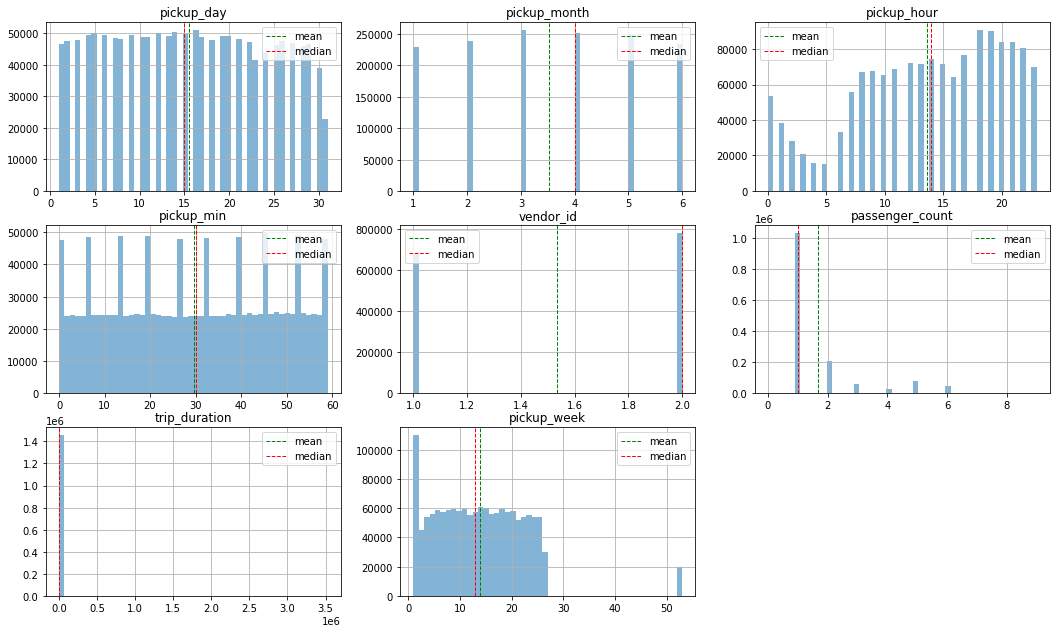

In [ ]:
#plotting distribution plot for each variable
num_columns=['pickup_day','pickup_month','pickup_hour','pickup_min','vendor_id','passenger_count','trip_duration','pickup_week']
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  df1[col].hist(bins=50,figsize=(18,18),alpha=0.55)
  mean=df1[col].mean()
  median=df1[col].median()
  plt.axvline(mean, color='green', linestyle='dashed', linewidth=1,label='mean')
  plt.axvline(median,color='red',linestyle='dashed', linewidth=1,label='median')
  plt.legend()
  plt.title(col)

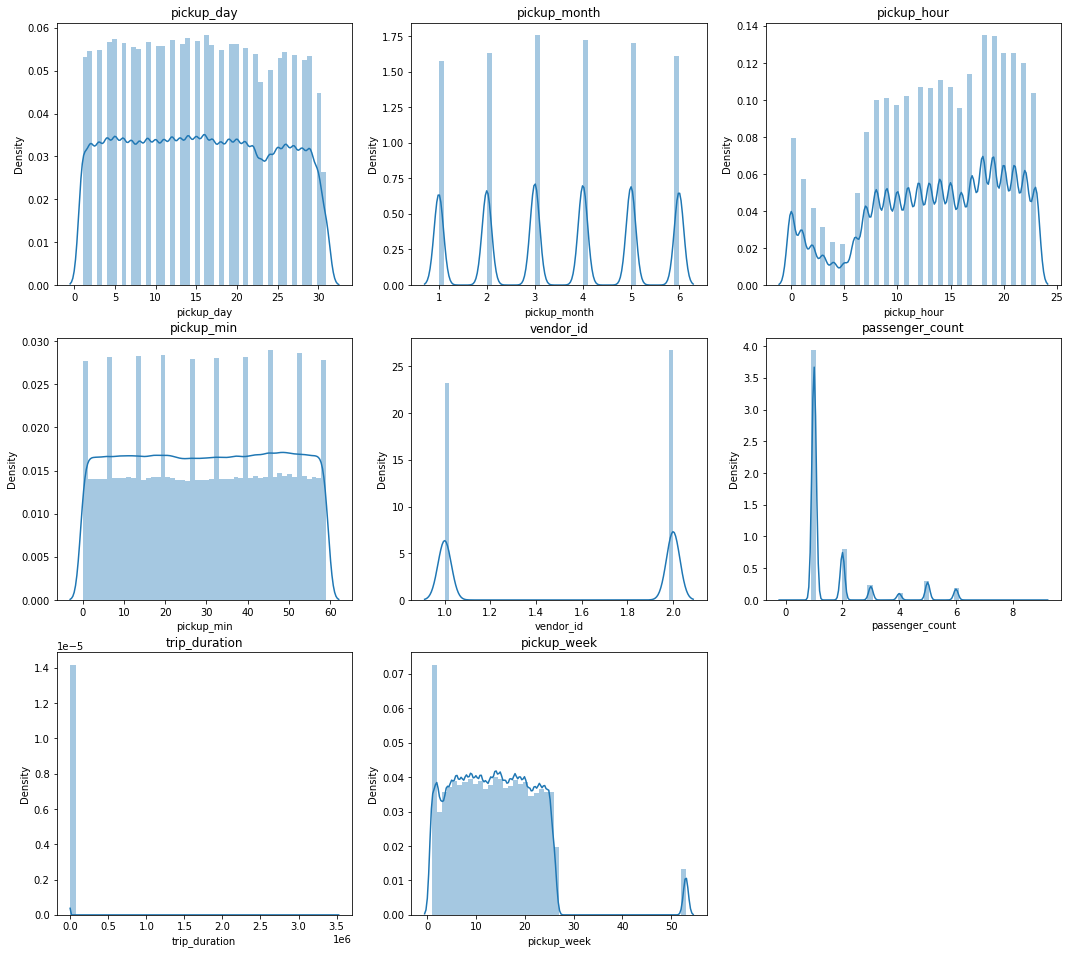

In [ ]:
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  var=df1[col]
  g=sns.distplot(var)
  g.figure.set_size_inches(18,28)
  plt.title(col)

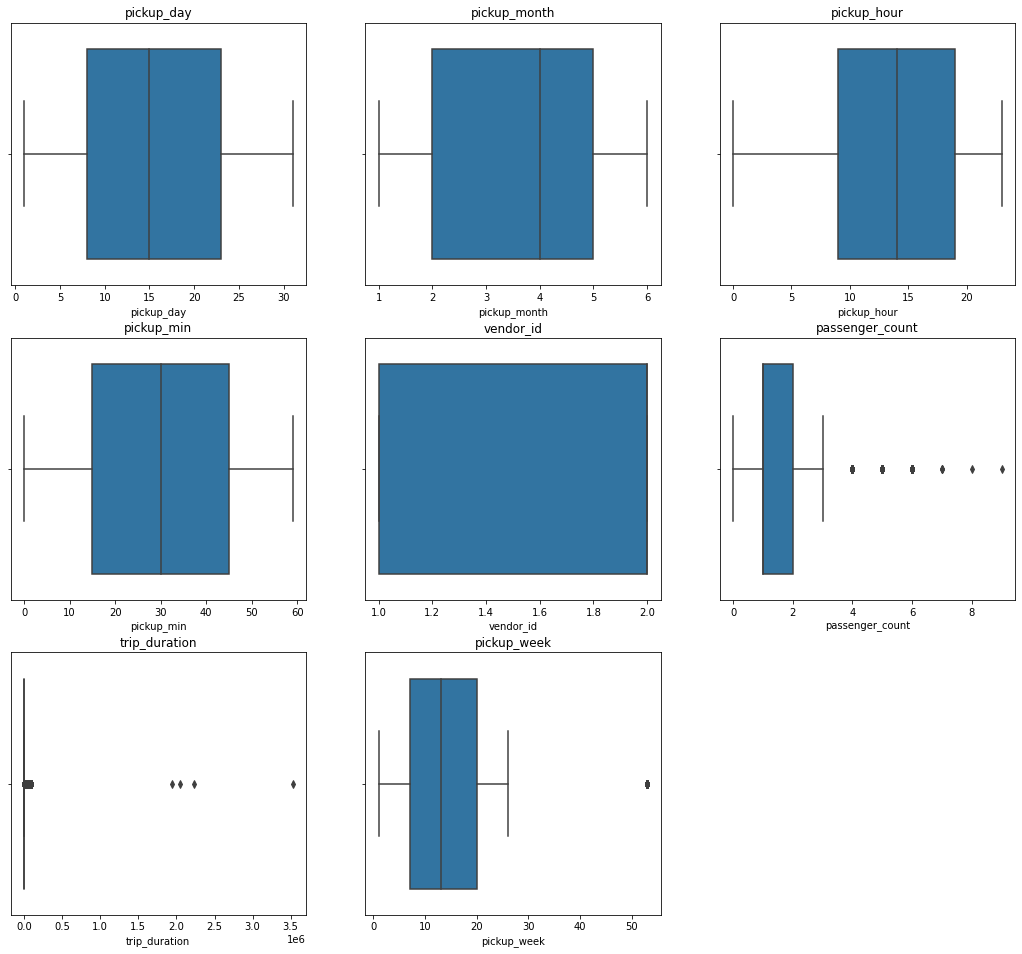

In [52]:
num_columns=['pickup_day','pickup_month','pickup_hour','pickup_min','vendor_id','passenger_count','trip_duration','pickup_week']
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  var=df1[col]
  g=sns.boxplot(var)
  g.figure.set_size_inches(18,28)
  plt.title(col)

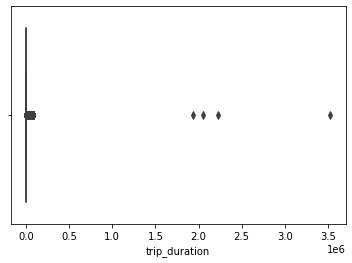

In [ ]:
sns.boxplot(df1['trip_duration'])

We have outliers, so we remove them:
1. First in trip duration we remove those trips which lasted for less than 100 seconds
2. Next we also remove those trips which lasted more than 10000 seconds.

In [ ]:
df1=df1[df1['trip_duration']>100]
df1=df1[df1['trip_duration']<10000]

In [ ]:
df1.shape

(1437232, 15)

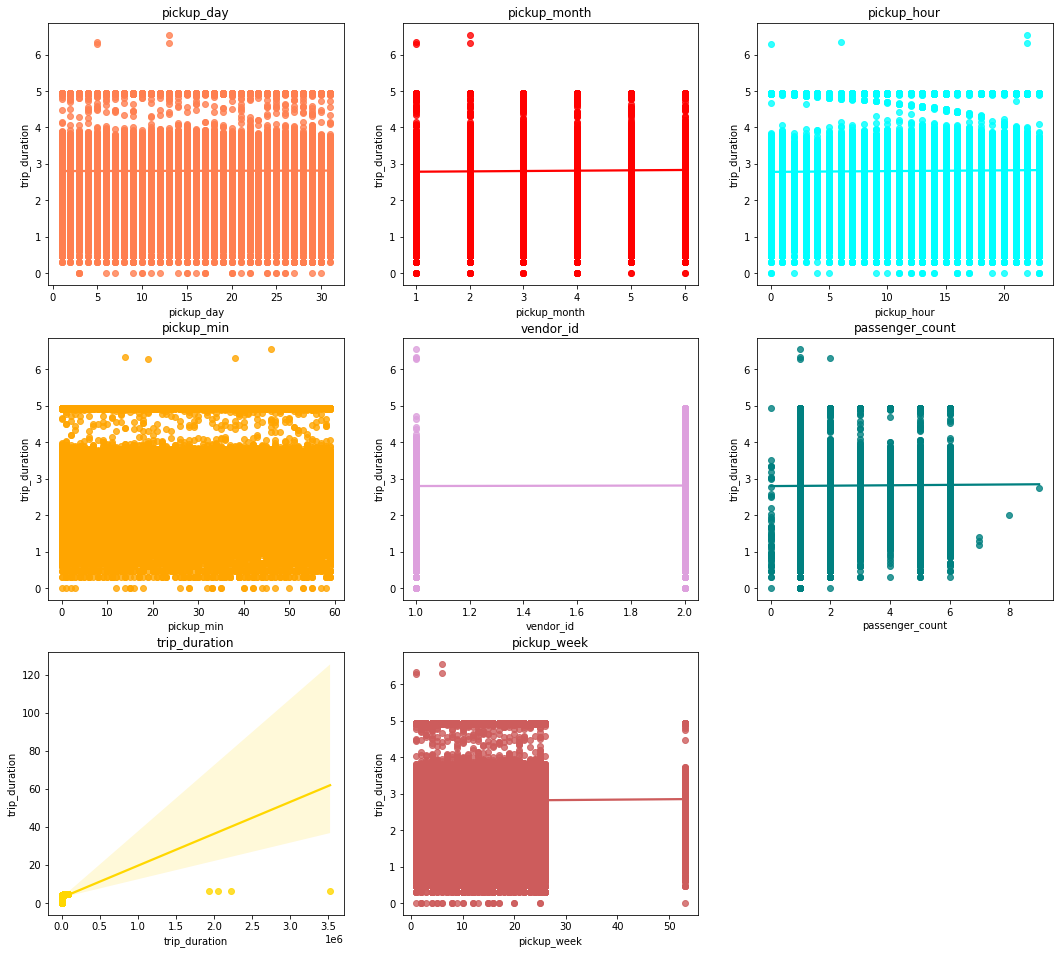

In [ ]:
colors=['coral','red','cyan','orange','plum','teal','gold','indianred','lime','indigo','seagreen','cornflowerblue','lawngreen','deepskyblue','chocolate']
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  var=df[col]
  g=sns.regplot(var, np.log10(df['trip_duration']),color=colors[i-1])
  g.figure.set_size_inches(18,28)
  plt.title(col)

Here we see that none of the variables have a linear relation with trip duration. So, linear regression may not give us the best results

#Further Data preparation

In [ ]:
df1.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,17,24,11
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,0,43,23
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,35,3
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,19,32,14
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,13,30,12


In [ ]:
df1['store_and_fwd_flag'].value_counts() # we remove this column because of output

N    1429370
Y       7862
Name: store_and_fwd_flag, dtype: int64

In [ ]:
df1.drop(columns=['store_and_fwd_flag'],inplace=True)

In [ ]:
df1.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_day', 'pickup_month',
       'pickup_hour', 'pickup_min', 'pickup_week'],
      dtype='object')

In [ ]:
df1=pd.get_dummies(df1, columns=['vendor_id'],prefix=['vid'])

In [ ]:
df1.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,14,3,17,24,11,0,1
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,12,6,0,43,23,1,0
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,19,1,11,35,3,0,1
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,6,4,19,32,14,0,1
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,26,3,13,30,12,0,1


In [ ]:
df1['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 9, 8])

In [ ]:
def get_passenger_value(X):
  ''' RETURNS A VALUE DEPENDING ON NUMBER OF PASSENGERS'''
  if -1<X<2:
    A=1
  elif 1<X<6:
    A=2
  else:
    A=3
  return A

In [ ]:
df1['passenger_count']=df1['passenger_count'].apply(get_passenger_value)

In [ ]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Now, we get distance as well
import haversine as hs
def get_distance(start_lat,start_long,end_lat,end_long):
  '''returns distance between pickup and dropoff'''
  loc1=(start_lat,start_long)
  loc2=(end_lat,end_long)
  return hs.haversine(loc1,loc2)


In [ ]:
df1['distance_in_km']=df1.apply(lambda X: get_distance(X['pickup_latitude'],X['pickup_longitude'],X['dropoff_latitude'],X['dropoff_longitude']),axis=1)

In [ ]:
df1.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2,distance_in_km
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,14,3,17,24,11,0,1,1.498523
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,12,6,0,43,23,1,0,1.805510
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,19,1,11,35,3,0,1,6.385107
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,6,4,19,32,14,0,1,1.485500
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,26,3,13,30,12,0,1,1.188590


In [ ]:
df1=df1.drop(columns=['pickup_datetime','dropoff_datetime'],axis=1)

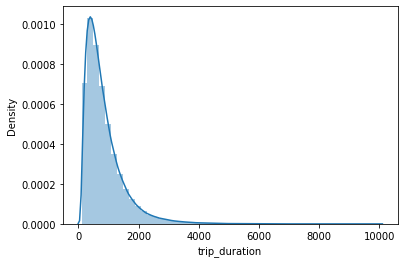

In [ ]:
sns.distplot(df1['trip_duration'])

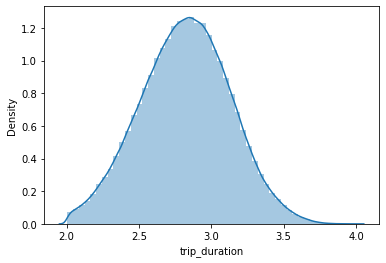

In [ ]:
sns.distplot(np.log10(df1['trip_duration']))

In [ ]:
df1.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2,distance_in_km
0,1,-73.982155,40.767937,-73.964630,40.765602,2.658011,14,3,17,24,11,0,1,1.498523
1,1,-73.980415,40.738564,-73.999481,40.731152,2.821514,12,6,0,43,23,1,0,1.805510
2,1,-73.979027,40.763939,-74.005333,40.710087,3.327155,19,1,11,35,3,0,1,6.385107
3,1,-74.010040,40.719971,-74.012268,40.706718,2.632457,6,4,19,32,14,0,1,1.485500
4,1,-73.973053,40.793209,-73.972923,40.782520,2.638489,26,3,13,30,12,0,1,1.188590


In [ ]:
X=df1[list(set(df1.columns)-{'trip_duration'})]
Y=np.log10(df1['trip_duration'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=1)

#Linear Regression : [click here](https://colab.research.google.com/drive/1Lkm50kwZBeIYJNcE9pZVd8M_MuQSpIYJ?usp=sharing)

#Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.inspection import permutation_importance


In [ ]:
tree_reg = DecisionTreeRegressor(criterion='squared_error',splitter='best',max_depth=10,min_samples_split=10000,min_samples_leaf=1000)

In [ ]:
tree_reg.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=1000,
                      min_samples_split=10000)

In [ ]:
y_pred=tree_reg.predict(X_test)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [ ]:
def get_adjusted_r2(X,Y): #X is actual and Y is pred
  return 1-(1-r2_score(X,Y))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

In [ ]:
#train errors and test errors
print(f'r2 score for train data is {r2_score(10**Y_train,10**tree_reg.predict(X_train))}')
print(f'r2 score for test data is{r2_score(10**Y_test,10**y_pred)}')
print(f'adjusted r2 score for train data is{get_adjusted_r2(10**Y_train,10**tree_reg.predict(X_train))}')
print(f'adjusted r2 score for test data is{get_adjusted_r2(10**Y_test,10**y_pred)}')

r2 score for train data is 0.6861247461299104
r2 score for test data is0.6850426044820102
adjusted r2 score for train data is0.686113389474079
adjusted r2 score for test data is0.6850312086720558


In [ ]:
import math
def get_mse(X,Y):
  MSE= mean_squared_error(X,Y)
  return math.sqrt(MSE)
def get_mape(X,Y):
  return mean_absolute_percentage_error(X,Y)

In [ ]:
#train and test errors MSE
print(f'MSE for train data is {get_mse(10**Y_train,10**tree_reg.predict(X_train))}')
print(f'MSE for test data is {get_mse(10**Y_test,10**y_pred)}')
#TRAIN AND TEST MAPE
print(f'MAPE for train data is {get_mape(10**Y_train,10**tree_reg.predict(X_train))}')
print(f'MAPE for test data is {get_mape(10**Y_test,10**y_pred)}')

RMSE for train data is 367.68784297220475
RMSE for test data is 367.8704627667884
MAPE for train data is 0.31278393614284844
MAPE for test data is 0.3142893485875397


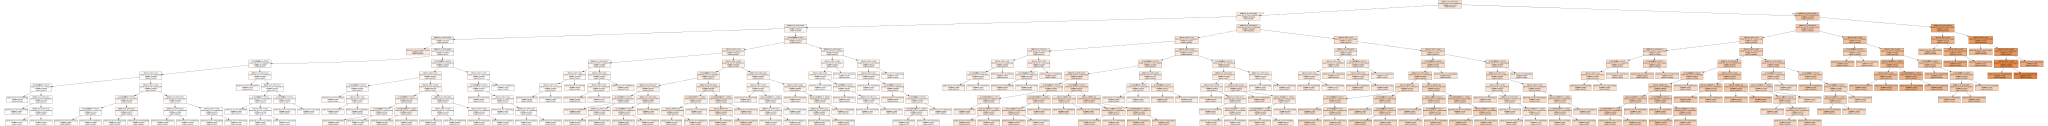

In [ ]:
graph = Source(tree.export_graphviz(tree_reg, out_file=None
   , feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [ ]:
tree_reg.feature_importances_

array([0.00000000e+00, 4.76478431e-04, 3.25993570e-03, 7.62024184e-02,
       1.80364624e-03, 0.00000000e+00, 0.00000000e+00, 8.95912364e-01,
       1.87143526e-02, 0.00000000e+00, 3.63080437e-03, 0.00000000e+00,
       0.00000000e+00])

Text(0.5, 0, 'Random Forest Feature Importance')

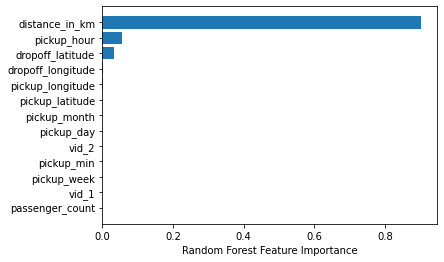

In [ ]:
sorted_idx = tree_reg.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], tree_reg.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 13.8 MB/s 


In [ ]:
import shap
shap.initjs()

In [ ]:
X_shap=X_train
explainer = shap.TreeExplainer(tree_reg)
shap_values = explainer.shap_values(X_shap)

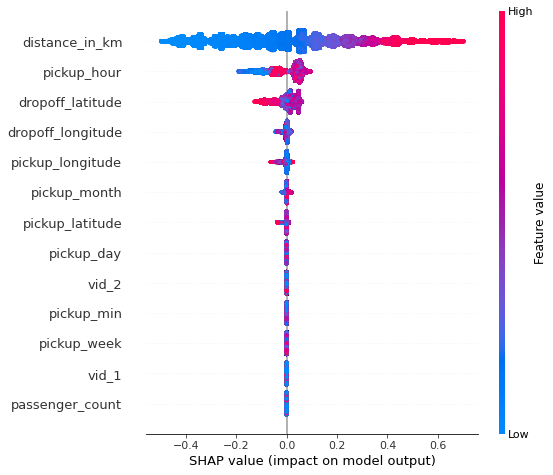

In [ ]:
shap.summary_plot(shap_values, X_shap)

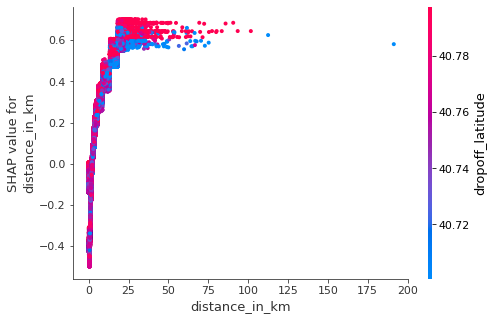

In [ ]:
shap.dependence_plot('distance_in_km',shap_values,X_train,xmax=200)

#Randomforest implementation

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#number of trees
n_estimators=[50,100]

#maximum depth of trees
max_depth=[5,8,10]

#Minimum number of samples required to split a node
min_samples_split=[1000,10000]

#min sample leaf
min_samples_leaf=[1000]

#hyperparameter grid
param_disct = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split}


In [ ]:
#initializing random forest model
rf_model=RandomForestRegressor()

#GridsearchCV
from sklearn.model_selection import GridSearchCV  
rf_grid=GridSearchCV(estimator=rf_model, param_grid=param_disct, 
                     cv=4,verbose=2,scoring='neg_mean_squared_error')

rf_grid.fit(X_train,Y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.7min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.3min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.3min
[CV] END max_depth=5, min_samp

GridSearchCV(cv=4, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 8, 10],
                         'min_samples_split': [1000, 10000],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [ ]:
rf_grid.best_params_

{'max_depth': 10, 'min_samples_split': 1000, 'n_estimators': 100}

In [ ]:
rf_optimal= RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=10,min_samples_split=800)

In [ ]:
rf_optimal.fit(X_train,Y_train)

RandomForestRegressor(criterion='mse', max_depth=10, min_samples_split=800)

In [ ]:
y_test_rf_pred=rf_optimal.predict(X_test)

In [ ]:
#train errors and test errors  r2 and adjusted r2
print(f'r2 score for train data is {r2_score(10**Y_train,10**rf_optimal.predict(X_train))}')
print(f'r2 score for test data is{r2_score(10**Y_test,10**y_test_rf_pred)}')
print(f'adjusted r2 score for train data is{get_adjusted_r2(10**Y_train,10**rf_optimal.predict(X_train))}')
print(f'adjusted r2 score for test data is{get_adjusted_r2(10**Y_test,10**y_test_rf_pred)}')

r2 score for train data is 0.7129208679618806
r2 score for test data is0.7110141538770642
adjusted r2 score for train data is0.7129104808451558
adjusted r2 score for test data is0.7110036977714805


In [ ]:
import math
def get_mse(X,Y):
  MSE= mean_squared_error(X,Y)
  return math.sqrt(MSE)
def get_mape(X,Y):
  return mean_absolute_percentage_error(X,Y)

In [ ]:
#train and test errors RMSE
print(f'MSE for train data is {get_mse(10**Y_train,10**rf_optimal.predict(X_train))}')
print(f'MSE for test data is {get_mse(10**Y_test,10**y_test_rf_pred)}')
#TRAIN AND TEST MAPE
print(f'MAPE for train data is {get_mape(10**Y_train,10**rf_optimal.predict(X_train))}')
print(f'MAPE for test data is {get_mape(10**Y_test,10**y_test_rf_pred)}')

RMSE for train data is 351.5865999320047
RMSE for test data is 352.2726570146112
MAPE for train data is 0.299668472361449
MAPE for test data is 0.301694963755809


#XGBoost

In [ ]:
import xgboost as xg
xgb_r = xg.XGBRegressor(max_depth=6, n_estimator=100, learning_rate=0.1, objective ='reg:linear',seed = 123)
XGmodel=xgb_r.fit(X_train,Y_train)

[07:24:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
xg_y_pred=XGmodel.predict(X_test)

In [ ]:
#train errors and test errors  r2 and adjusted r2
print(f'r2 score for train data is {r2_score(10**Y_train,10**XGmodel.predict(X_train))}')
print(f'r2 score for test data is{r2_score(10**Y_test,10**xg_y_pred)}')
print(f'adjusted r2 score for train data is{get_adjusted_r2(10**Y_train,10**XGmodel.predict(X_train))}')
print(f'adjusted r2 score for test data is{get_adjusted_r2(10**Y_test,10**xg_y_pred)}')

r2 score for train data is 0.7551077306162512
r2 score for test data is0.7545482315087211
adjusted r2 score for train data is0.7550988699074669
adjusted r2 score for test data is0.7545393505561018


In [ ]:
#train and test errors MSE
print(f'RMSE for train data is {get_mse(10**Y_train,10**XGmodel.predict(X_train))}')
print(f'RMSE for test data is {get_mse(10**Y_test,10**xg_y_pred)}')
#TRAIN AND TEST MAPE
print(f'MAPE for train data is {get_mape(10**Y_train,10**XGmodel.predict(X_train))}')
print(f'MAPE for test data is {get_mape(10**Y_test,10**xg_y_pred)}')

RMSE for train data is 324.7792467508347
RMSE for test data is 324.7521957753851
MAPE for train data is 0.2725390847289322
MAPE for test data is 0.2737855267112696


#Metrics of the models

##Metrics for train data of linear regressions

In [ ]:
pd.DataFrame({'LinearRegression(Train)':{'R2':0.79,'Adjusted R2':0.79, 'MSE':216843977.42, 'RMSE':(216843977.42)**0.5,'MAPE':0.292},
              'LassoRegression(Train)':{'R2':0.017,'Adjusted R2':0.017, 'MSE':182654462.24, 'RMSE':13514.97,'MAPE':0.291},
              'RidgeRegression(Train)':{'R2':0.015,'Adjusted R2':0.015, 'MSE':216843868.8, 'RMSE':14725.61,'MAPE':0.292},
              'ElasticNetRegression(Train)':{'R2':0.032,'Adjusted R2':0.032, 'MSE':71643820.52, 'RMSE':8464.26,'MAPE':0.2906},
              'LinearRegression(Test)':{'R2':0.014,'Adjusted R2':-582.87, 'MSE':251016607.51, 'RMSE':(251016607.51)**0.5,'MAPE':0.29},
              'LassoRegression(Test)':{'R2':0.014,'Adjusted R2':0.014, 'MSE':229259958, 'RMSE':15141.33,'MAPE':0.29},
              'RidgeRegression(Test)':{'R2':0.014,'Adjusted R2':0.014, 'MSE':251016537.60, 'RMSE':15843.5,'MAPE':0.29},
              'ElasticnetRegression(Test)':{'R2':-211.74,'Adjusted R2':-211.75, 'MSE':455036587.60, 'RMSE':(455036587.60)**0.5,'MAPE':0.29}}).transpose()

,R2,Adjusted R2,MSE,RMSE,MAPE
LinearRegression(Train),0.790,0.790,2.168440e+08,14725.623159,0.2920
LassoRegression(Train),0.017,0.017,1.826545e+08,13514.970000,0.2910
RidgeRegression(Train),0.015,0.015,2.168439e+08,14725.610000,0.2920
ElasticNetRegression(Train),0.032,0.032,7.164382e+07,8464.260000,0.2906
LinearRegression(Test),0.014,-582.870,2.510166e+08,15843.503637,0.2900
LassoRegression(Test),0.014,0.014,2.292600e+08,15141.330000,0.2900
RidgeRegression(Test),0.014,0.014,2.510165e+08,15843.500000,0.2900
ElasticnetRegression(Test),-211.740,-211.750,4.550366e+08,21331.586617,0.2900


##Metrics for ensemble tree models

In [ ]:
pd.DataFrame({'DecisionTree(Train)':{'R2':0.68,'Adjusted R2':0.68,'MSE':367.68,'RMSE':(367.68)**0.5,'MAPE':0.31},
              'DecisionTree(Test)':{'R2':0.68,'Adjusted R2':0.68,'MSE':367.68,'RMSE':(367.87)**0.5,'MAPE':0.31},
              'RandomForest(Train)':{'R2':0.71,'Adjusted R2':0.71,'MSE':351,'RMSE':(351)**0.5,'MAPE':0.29},
              'RandomForest(Test)':{'R2':0.71,'Adjusted R2':0.71,'MSE':351,'RMSE':(351)**0.5,'MAPE':0.30},
              'XGBoost(Train)':{'R2':0.75,'Adjusted R2':0.75,'MSE':324,'RMSE':(324)**0.5,'MAPE':0.27},
              'XGBoost(Test)':{'R2':0.75,'Adjusted R2':0.75,'MSE':324,'RMSE':(324)**0.5,'MAPE':0.27}}).transpose()

,R2,Adjusted R2,MSE,RMSE,MAPE
DecisionTree(Train),0.68,0.68,367.68,19.174984,0.31
DecisionTree(Test),0.68,0.68,367.68,19.179937,0.31
RandomForest(Train),0.71,0.71,351.00,18.734994,0.29
RandomForest(Test),0.71,0.71,351.00,18.734994,0.30
XGBoost(Train),0.75,0.75,324.00,18.000000,0.27
XGBoost(Test),0.75,0.75,324.00,18.000000,0.27
